In [1]:
import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib.patches import Polygon

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

In [2]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0.0, 0.0, 0.0], scale=1.0):
    """Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    scale (float): scale of cube

    """
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array(
        [
            (0, 0, 0),
            (0, 0, 1),
            (0, 1, 0),
            (0, 1, 1),
            (1, 0, 0),
            (1, 0, 1),
            (1, 1, 0),
            (1, 1, 1),
        ]
    )
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler("xyz", rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array(
        [
            # all faces containing (0, 0, 0)
            [corners[0], corners[1], corners[3], corners[2]],
            [corners[0], corners[1], corners[5], corners[4]],
            [corners[0], corners[2], corners[6], corners[4]],
            # all faces containing (1, 1, 1)
            [corners[-1], corners[-2], corners[-4], corners[-3]],
            [corners[-1], corners[-2], corners[-6], corners[-5]],
            [corners[-1], corners[-3], corners[-7], corners[-5]],
        ]
    )

    return faces

In [3]:
def get_camera_intrinsics(alpha=70, beta=70, cx=W / 2.0, cy=H / 2.0):
    """Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    alpha (float): focal length in x-direction f_x
    beta (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    """
    K = np.array([[alpha, 0, cx], [0, beta, cy], [0, 0, 1]], dtype=np.float32)

    return K

In [4]:
def get_perspective_projection(x_c, K):
    """Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.

    Args:
        x_c (array): 3D points in camera space (nx3), n is the num of points
        K (array): camera intrinsics matrix (3x3)
    """
    x_c_homog = np.hstack((x_c, np.ones((x_c.shape[0], 1))))
    x_s_homog = np.dot(K, x_c_homog.T).T
    x_s = x_s_homog[:, :2] / x_s_homog[:, 2:]

    return x_s

In [5]:
def project_cube(cube, K):
    """Projects the cube.

    Args:
        cube (array): cube (6x4x3)
        K (array): camera intrinsics matrix (3x3)
    """
    vertices = cube.reshape(-1, 3)
    projected_vertices_homogeneous = np.dot(K, vertices.T).T
    projected_vertices = (
        projected_vertices_homogeneous[:, :2] / projected_vertices_homogeneous[:, 2:]
    )
    projected_cube = projected_vertices.reshape(cube.shape[0], cube.shape[1], 2)

    return projected_cube

In [6]:
def plot_projected_cube(ax, projected_cube):
    """Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    """
    for face in projected_cube:
        polygon = Polygon(
            face, closed=True, fill=True, edgecolor="none", facecolor="b", alpha=0.5
        )

        ax.add_patch(polygon)

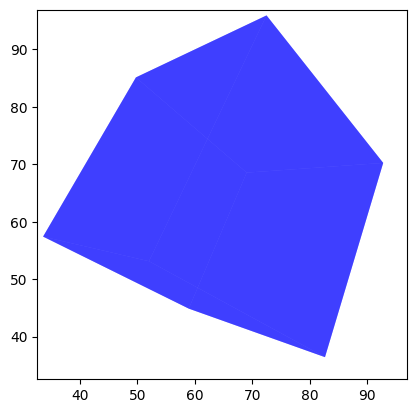

In [7]:
K = get_camera_intrinsics(alpha=70, beta=70, cx=64, cy=64)
cube = get_cube(center=[0, 0, 2], rotation_angles=[30, 50, 0], scale=1.0)
projected_cube = project_cube(cube, K)

fig, ax = plt.subplots()
x_min, x_max = np.min(projected_cube), np.max(projected_cube)
y_min, y_max = np.min(projected_cube), np.max(projected_cube)
ax.set_xlim(x_min - 1, x_max + 1)
ax.set_ylim(x_min - 1, x_max + 1)
ax.set_aspect("equal")

plot_projected_cube(ax, projected_cube)
plt.show()

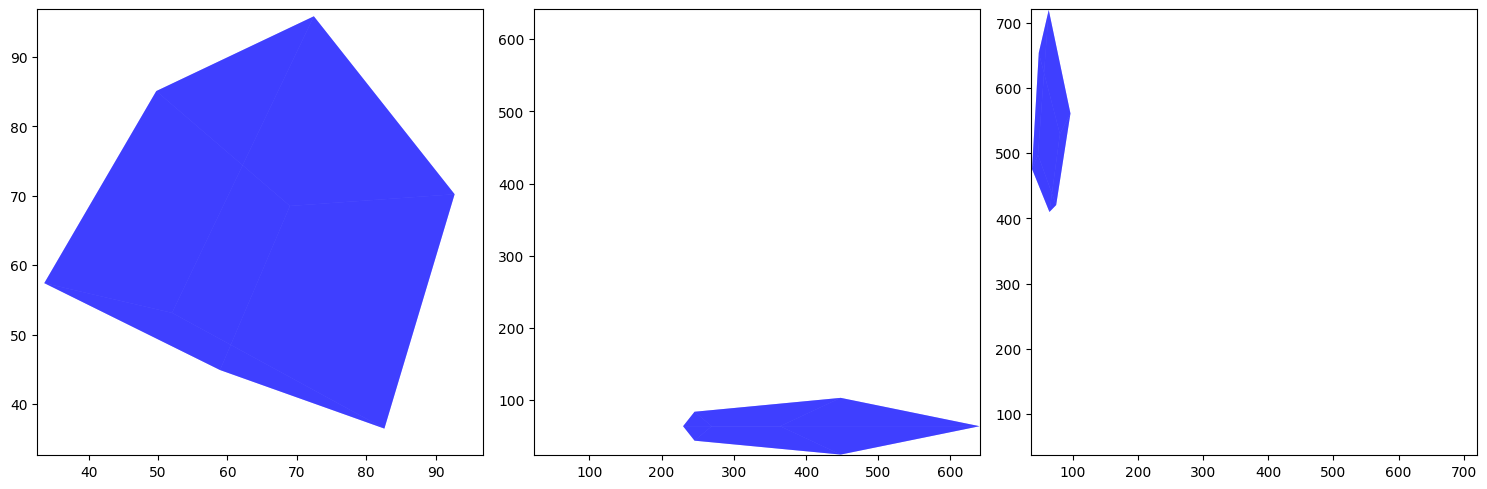

In [8]:
# Explore with settings
settings = [
    {
        "alpha": 70,
        "beta": 70,
        "center": [0, 0, 2],
        "rotation_angles": [30, 50, 0],
        "scale": 1.0,
    },
    {
        "alpha": 50,
        "beta": 50,
        "center": [10, 0, 2],
        "rotation_angles": [45, 60, 0],
        "scale": 1.5,
    },
    {
        "alpha": 90,
        "beta": 90,
        "center": [0, 10, 2],
        "rotation_angles": [30, 50, 45],
        "scale": 0.8,
    },
]

fig, axs = plt.subplots(
    1, len(settings), figsize=(15, 5)
)  # Adjust the layout as needed
for ax, setting in zip(axs, settings):
    K = get_camera_intrinsics(
        alpha=setting["alpha"], beta=setting["beta"], cx=64, cy=64
    )
    cube = get_cube(
        center=setting["center"],
        rotation_angles=setting["rotation_angles"],
        scale=setting["scale"],
    )
    projected_cube = project_cube(cube, K)

    x_min, x_max = np.min(projected_cube), np.max(projected_cube)
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(x_min - 1, x_max + 1)
    ax.set_aspect("equal")

    plot_projected_cube(ax, projected_cube)

fig.tight_layout()
plt.show()